In [13]:
from collections import defaultdict
from typing import List

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hassediagram.hasse_diagram import hasse_graphviz
import numpy as np
import pandas as pd

from mcda.dataset import MCDADataset
from mcda.uta import Criterion, calculate_uta_gms

In [21]:
import argparse
import warnings
from collections import defaultdict
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from umap import UMAP
import matplotlib.pyplot as plt
from hassediagram.hasse_diagram import hasse_graphviz

from mcda.dataset import MCDADataset
from mcda.report import calculate_heuristics
from mcda.uta import Criterion, calculate_uta_gms

In [22]:
n_components = [2, 3, 4, 5, 6]

In [23]:
def is_dominating(a_values: List[float], b_values: List[float]) -> bool:
    """
    Check if a is dominating b

    Parameters
    ----------
    a_values (List[float, ...]): List of performances for a
    b_values (List[float, ...]): List of performances for b

    Returns
    -------
    bool: True if a is dominating b, False otherwise

    """
    return all(a >= b for a, b in zip(a_values, b_values)) and any(a > b for a, b in zip(a_values, b_values))


def get_domination_df(n_components: List[int], dataset: MCDADataset) -> pd.DataFrame:
    """
    Get a DataFrame with domination relations for each method and original dataset.

    Parameters
    ----------
    n_components (List[int]): List of number of components for methods
    dataset (MCDADataset): Dataset to check domination relations

    Returns
    -------
    pd.DataFrame: DataFrame with domination relations for each method and original dataset. Indices are tuples that can be passed to `preferences`.
    """

    # Scaling data for methods
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(dataset.data), columns=dataset.data.columns)

    domination = defaultdict(dict)
    for n in n_components:
        # check for each method
        methods = get_methods(n)
        for method_name, method in methods.items():
            df_m = (
                pd.DataFrame(method.fit_transform(df_scaled), index=dataset.data.index, columns=range(n))
                .map(lambda x: f"{x:.4f}")
                .astype(np.float64)
            )
            for alt_1 in df_m.index:
                for alt_2 in df_m.index:
                    if alt_1 == alt_2:
                        continue
                    domination[(method_name, n)][(alt_2, alt_1)] = is_dominating(
                        df_m.loc[alt_1, :].tolist(), df_m.loc[alt_2, :].tolist()
                    )

        # check for original dataset
        for alt_1 in dataset.data.index:
            for alt_2 in dataset.data.index:
                if alt_1 == alt_2:
                    continue
                domination[("original", n)][(alt_2, alt_1)] = is_dominating(
                    dataset.data.loc[alt_1, :].tolist(), dataset.data.loc[alt_2, :].tolist()
                )

    df_domination = pd.DataFrame(domination)
    return df_domination[df_domination.eq(False).all(axis=1)]

In [24]:
def get_methods(n: int) -> dict:
    """
    Get a dictionary of methods for dimensionality reduction.

    Parameters
    ----------
    n (int): Number of components for the methods.

    Returns
    -------
    dict: Dictionary of methods.

    """
    return {"PCA": PCA(n_components=n, random_state=42)}

In [25]:
dataset: MCDADataset = MCDADataset.read_csv("./data/insulating-materials/dataset.csv")

df_domination = get_domination_df(n_components, dataset)
preferences_list = [df_domination.index.to_series().sample(3, random_state=i).tolist() for i in range(10)]
print(preferences_list)
preferences = preferences_list[0]

[[('a5', 'a1'), ('a10', 'a4'), ('a5', 'a3')], [('a6', 'a8'), ('a1', 'a10'), ('a5', 'a6')], [('a3', 'a8'), ('a1', 'a3'), ('a12', 'a4')], [('a7', 'a9'), ('a5', 'a8'), ('a7', 'a12')], [('a5', 'a2'), ('a7', 'a9'), ('a12', 'a4')], [('a10', 'a5'), ('a3', 'a5'), ('a6', 'a7')], [('a1', 'a8'), ('a12', 'a2'), ('a6', 'a3')], [('a10', 'a2'), ('a5', 'a3'), ('a9', 'a11')], [('a6', 'a1'), ('a4', 'a1'), ('a4', 'a12')], [('a9', 'a1'), ('a8', 'a6'), ('a1', 'a4')]]


# Oryginalne dane

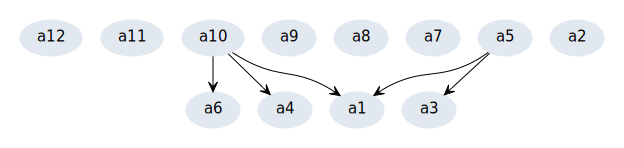

In [26]:
criteria = [Criterion(name, points=2) for name in dataset.data.columns]
df_utagms = calculate_uta_gms(dataset.data, preferences, criteria)
hasse_graphviz(df_utagms.values)

# PCA - n_components 2

In [38]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(dataset.data), columns=dataset.data.columns, index=dataset.data.index)

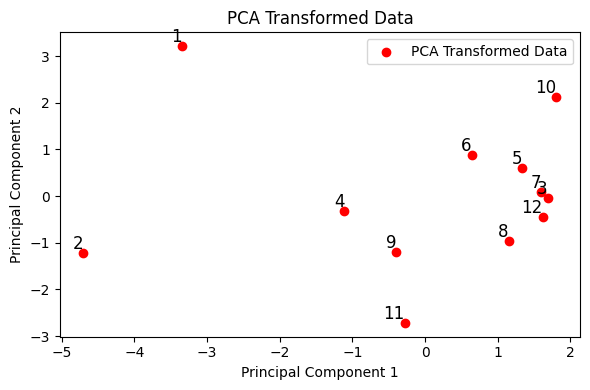

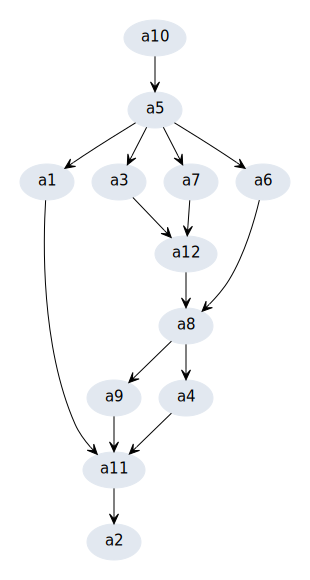

In [39]:
N_components = 2
pca = PCA(n_components=N_components)
transformed_data = pca.fit_transform(df_scaled)

# Plot original data
plt.figure(figsize=(6, 4))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], color="red", label="PCA Transformed Data")
for i, (x, y) in enumerate(transformed_data, start=1):
    plt.text(x, y, str(i), fontsize=12, ha="right", va="bottom")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Transformed Data")
plt.legend()

plt.tight_layout()
plt.show()

df_m = (
    pd.DataFrame(transformed_data, index=df_scaled.index, columns=range(N_components))
    .map(lambda x: f"{x:.4f}")
    .astype(np.float64)
)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

In [40]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2f}")
print(f"Explained variance by PC2: {explained_variance[1]:.2f}")

Explained variance by PC1: 0.59
Explained variance by PC2: 0.33


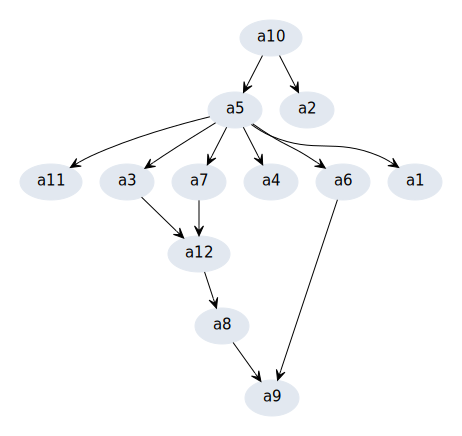

In [29]:
n_components = 3
df_m = (
    pd.DataFrame(
        PCA(n_components=n_components).fit_transform(df_scaled), index=df_scaled.index, columns=range(n_components)
    )
    .map(lambda x: f"{x:.4f}")
    .astype(np.float64)
)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

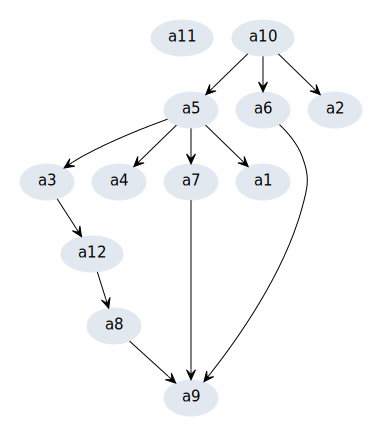

In [30]:
n_components = 4
df_m = (
    pd.DataFrame(
        PCA(n_components=n_components).fit_transform(df_scaled), index=df_scaled.index, columns=range(n_components)
    )
    .map(lambda x: f"{x:.4f}")
    .astype(np.float64)
)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

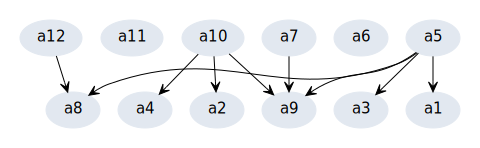

In [31]:
n_components = 5
df_m = (
    pd.DataFrame(
        PCA(n_components=n_components).fit_transform(df_scaled), index=df_scaled.index, columns=range(n_components)
    )
    .map(lambda x: f"{x:.4f}")
    .astype(np.float64)
)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

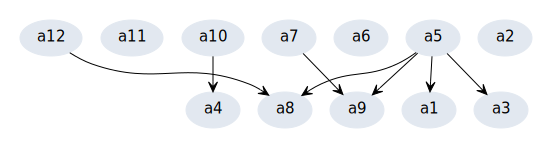

In [32]:
n_components = 6
df_m = (
    pd.DataFrame(
        PCA(n_components=n_components).fit_transform(df_scaled), index=df_scaled.index, columns=range(n_components)
    )
    .map(lambda x: f"{x:.4f}")
    .astype(np.float64)
)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)

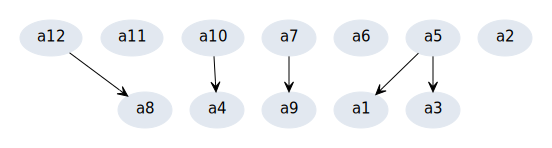

In [33]:
n_components = 7
df_m = (
    pd.DataFrame(
        PCA(n_components=n_components).fit_transform(df_scaled), index=df_scaled.index, columns=range(n_components)
    )
    .map(lambda x: f"{x:.4f}")
    .astype(np.float64)
)
criteria = [Criterion(name, points=2) for name in df_m.columns]
df_utagms = calculate_uta_gms(df_m, preferences, criteria)
hasse_graphviz(df_utagms.values)